In [1]:
%matplotlib inline

In [12]:
from PIL import Image

import os

import pprint
import time
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T

In [13]:
def show_image(data, class_list=None):
    image, label = data
    image = image.numpy().transpose((1, 2, 0))
        
    if class_list:
        label = class_list[label]
        
    plt.title(label)
    plt.imshow(image)

If you recall, our breakdown of machine learning was:
- data
- model
- training.

We're going to go into more detail on these:
- data
    - dataset
    - dataloader
    - data augmentation
- model
    - neural network layer
    - activation function
- training
    - loss function
    - optimizer
    
With data, we've covered the datasets and dataloaders, so we're going to talk about data augmentation.
What is data augmentation?
Recall Mason's talk about feature engineering.
The method is similar to feature engineering, but the purpose is different.
Often, we're constrained by lack of data and one method to artificially increase the amount of data we have at our disposal.
But be careful!
If you cannot make a prediction after you augment your data, then it's likely that your model might not be able to make a prediction.

Recall the [TensorFlow playground](https://playground.tensorflow.org/).
While this isn't actually a data augmentation, the same methods will be used when we work on data augmentation.
Depending on which features we choose, though, this could be data augmentation.
When we open the page, on the left hand side are the input features.

Remember our `torch.utils.data.Dataset` class.
One of the parameters was a `transform` parameter.
We're going to call a dataset of pairs of numbers $(x_{1}, x_{2})$ and we're going to implement transforms on these, using the `torch.utils.data.Dataset` class.

First, we're going to create a subclass.

In [14]:
class Transform(object):
    
    def __init__(self):
        pass
        
    def __call__(self, x):
        raise NotImplementedError

Now, we're going to implement three data augmentations:
- transform $(x_{1}, x_{2})$ to $(x_{1}^{2}, x_{2}^{2})$;
- transform $(x_{1}, x_{2})$ to $(x_{1} x_{2})$;
- transform $(x_{1}, x_{2})$ to $(\sin(x_{1}), \sin(x_{2}))$
using the `Transform` class we made.

There are two classes that need to be implemented for our `Transform` class: `__init__` and `__call__`.
Let's work on implementing the first transform.

In [15]:
class Square(Transform):
    
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        return torch.square(x)

In [16]:
square = Square()

In [17]:
transforms = torchvision.transforms.Compose([
    T.ToTensor(),
    Square()
])

In [18]:
ds_square = torchvision.datasets.MNIST(root='./data', transform=transforms, download=True)

In [19]:
ds = torchvision.datasets.MNIST(root='./data', transform=T.ToTensor(), download=True)

In [27]:
num = torch.randint(low=0, high=len(ds), size=(1, )).item()
print(num)

28273


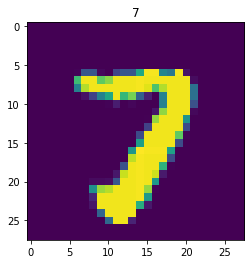

In [28]:
show_image(ds_square[num])

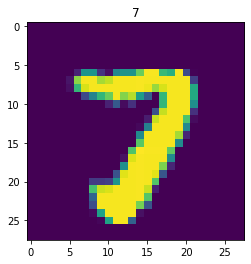

In [29]:
show_image(ds[num])

We'll work on implementing the other two transforms.

In [30]:
class Mult(Transform):
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        raise NotImplementedError

In [31]:
mult = Mult()

In [32]:
mult(torch.tensor([1, 2]))

NotImplementedError: 

In [33]:
class Sin(Transform):
    
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        raise NotImplementedError

In [35]:
transforms = torchvision.transforms.Compose([
    T.ToTensor(),
    Sin()
])

In [36]:
ds = torchvision.datasets.MNIST(root='./data', transform=transforms)

In [37]:
show_image(ds[0])

NotImplementedError: 

We're going to run through some of the pre-built transforms in the Pytorch library.
These are going to be transforms that are primarily useful for computer vision.
- normalization
- color jitter
- random rotation
- Gaussian Blur
- MixUp
- Label Smoothing

The first one we'll work through is the normalization.
The one requires us to know mean and standard deviation of the dataset.
You covered this in the module with Mason last week.
I won't cover them, I'll just talk about the Pytorch functions:
- `torch.mean(input, dim, keepdim)`
- `torch.std(input, dim, keepdim)`

Both of these input a tensor the parameter `dim` can be either an `int` or a `tuple` of `int`s.
If we input a tensor of shape $(16, 3, 224, 224)$ and $dim=1$, then we sum over the channels and then divide by 3.
`keepdim` is a boolean it returns a tensor with the same number of dimensions (i.e. the length of the tensor shape).

In [38]:
x = torch.randn((16, 3, 224, 224))

In [39]:
torch.mean(x, dim=1).shape

torch.Size([16, 224, 224])

In [40]:
x = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], dtype=torch.float)

In [41]:
x

tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])

In [42]:
torch.mean(x, dim=1)

tensor([[2., 3.],
        [6., 7.]])

We calculate over just the rows!
So, `torch.mean(x, dim=1)` returns:
$$
\begin{pmatrix}
(1 + 3) / 2 & (2 + 4) / 2 \\
(5 + 7) / 2 & (6 + 8) / 2
\end{pmatrix} =
\begin{pmatrix}
2 & 3 \\
6 & 7
\end{pmatrix}
$$

In [43]:
torch.mean(x, dim=0)

tensor([[3., 4.],
        [5., 6.]])

With this one, we just added the elements of the matrix together!d
$$
\begin{pmatrix}
(1 + 5) / 2 & (2 + 6) / 2 \\
(3 + 7) / 2 & (4 + 8) / 2
\end{pmatrix} =
\begin{pmatrix}
4 & 4 \\
5 & 6
\end{pmatrix}
$$

In [44]:
torch.mean(x, dim=2)

tensor([[1.5000, 3.5000],
        [5.5000, 7.5000]])

`torch.std` works similarly.

Now, we want to talk about normalization.
Why is it called normalization?
The most important probability distribution is called the normal distribution.
In a sense, it's the simplest mathematically, but more importantly, if we have enough probability distributions they become a lot like a normal distribution.
Additionally, the normal distribution can be completely described by the mean and standard deviation.
This means that the simplest normal distribution is the normal distribution with mean $0$ and standard deviation $1$.

What we do when we normalization is transform our data so they have mean $0$ and standard deviation $1$.

If $X$ is our data, $\mu$ is the mean of our data, and $\sigma$ is the standard deviation of our data, then the normalization of $X$ is
$$
\frac{X - \mu}{\sigma}
$$

This is called with

`torchvision.transforms.Normalize(mean, std)`

It takes in a tensor with the mean and a tensor with the std and outputs a function.

We'll talk about color jitter next.
First, we'll open an image.
Then we'll resize it 

In [45]:
image1 = Image.open('./images/laicc_group_photo.jpeg')
image2 = Image.open('./images/prairie_dog.jpg')

In [46]:
img1 = torchvision.transforms.Resize((384, 512))(image1)
img2 = torchvision.transforms.Resize((384, 512))(image2)

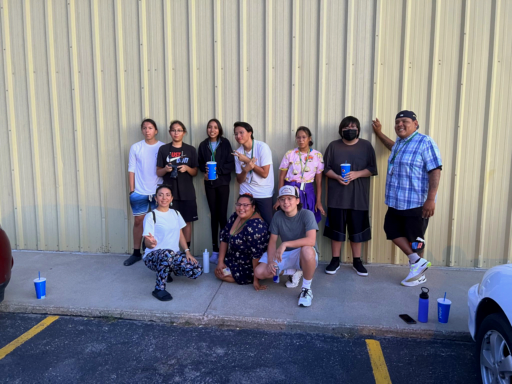

In [58]:
torchvision.transforms.ColorJitter(brightness=.5, contrast=.1, saturation=0.75, hue=0.1)(img1)

Now, we'll look at random rotation: `torchvision.transforms.RandomRotation(degrees)`.
The `degrees` parameter is either an `int` or a `tuple` of two `int`s.
If it's an `int`, the rotation is between `(-degrees, degrees)`.
If it's two `int`s, say `(min, max)`, then it rotates between those two values.
This just rotates the image.

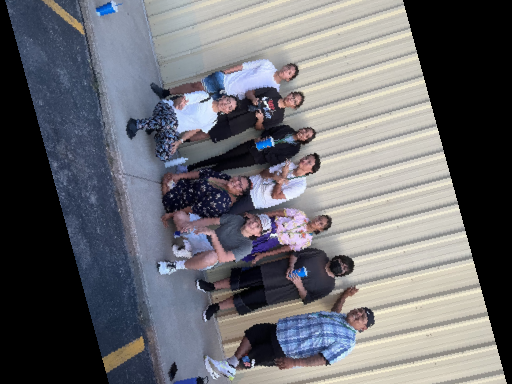

In [68]:
degrees = 80
torchvision.transforms.RandomRotation(degrees)(img1)

The next we'll look at is `torchvision.transforms.GaussianBlur`.
This works similarly to `torchvision.nn.functional.conv2d`.
The kernel weights come from the normal distribution (which is also called the Gaussian distribution).

`torchvision.transforms.GaussianBlur` has two parameters, `kernel_size` and `sigma`.
The `kernel_size` is similar to what we did with convolutional layers.
**Note**: the `kernel_size` must have only odd integer values.
The value `sigma` represents the standard deviation and it is either a `float` or a `tuple` of `float`s.
If it's a single `float`, then it's fixed.
If it's a `tuple` of `float`s, say `(min, max)`, then the standard deviation is randomly selected from `(min, max)`.

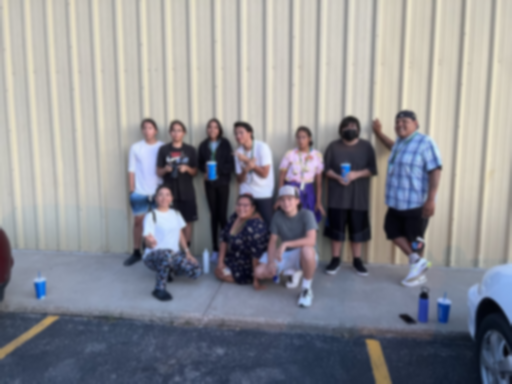

In [83]:
torchvision.transforms.GaussianBlur((5, 13), (0.1, 5))(img1)

The next is `torchvision.transforms.RandomPerspective(distortion_scale, p)`.
The `distortion_scale` controls how distorted it is, with `0` being no distortion and 1 being completely distorted.
The value `p` tells us what probability the image will be distorted.
If it is 0.5, then it's a random perspective 50% of the time.

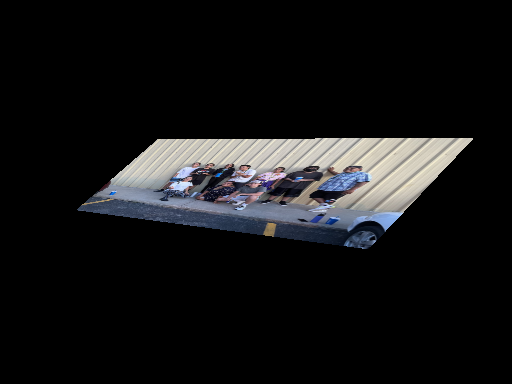

In [94]:
torchvision.transforms.RandomPerspective(1, .75)(img1)

The next one we'll loook at is `torchvision.transforms.RandomCrop(size)`.
This is how large we want the output to be. It is either an `int` or a `tuple` of two `int`s.
If an `int`, it will give a square output instead of the output of a tpule of ints.

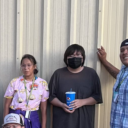

In [107]:
size = 128
torchvision.transforms.RandomCrop(size)(img1)

Next is `torchvision.transforms.RandomInvert(p)`.
Here `p` is just the probability that we perform an inversion of the colors.

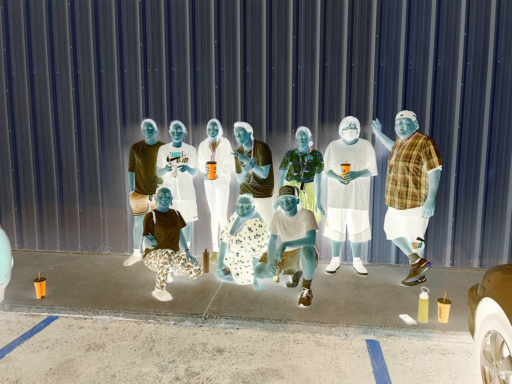

In [132]:
torchvision.transforms.RandomInvert(.9)(img1)

Now, we're going to talk about MixUp.
MixUp combines two images and their labels.
So, if we had an image of a dog and a cat out of 10 classes, then they would an `image1` and `image2` and have labels that are one-hot encoded as
$$
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
$$
and
$$
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0].
$$
We have a constant called $\lambda$ and we combine the images and labels with the following equations:
$$
\lambda image1 + (1 - \lambda) image2
$$
and the labels would be
$$
[\lambda, 1 - \lambda, 0, 0, 0, 0, 0, 0, 0, 0]
$$

We get the number $\lambda$ by sampling from what is called the beta distribution.
We would get this lambda with this code:

In [133]:
alpha = 0.1

lam = torch.distributions.beta.Beta(alpha, alpha).sample()

In [134]:
lam.item()

0.9976731538772583

In [135]:
combined = lam * T.ToTensor()(img1) + (1 - lam) * T.ToTensor()(img2)

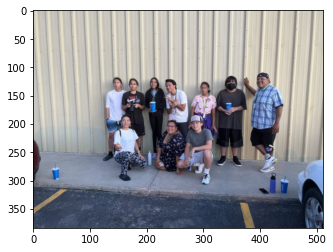

In [150]:
lam = torch.distributions.beta.Beta(alpha, alpha).sample()
combined = lam * T.ToTensor()(img1) + (1 - lam) * T.ToTensor()(img2)
show_image((combined, None))

So, why MixUp?
This primarily has to do with how predictions are made and the gradients.
If our predictions are too confident, our gradients get close to zero.
This stops our training.
MixUp helps with gradients.

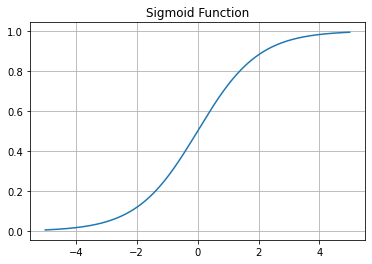

In [151]:
x = np.arange(-5.0, 5.0, 0.01)
y = torch.sigmoid(torch.tensor(x)).numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

plt.title('Sigmoid Function')
ax.grid()
plt.show()

In [152]:
def mixup_data(x, y, alpha=0.1, use_cuda=True):
    # This is code from the authors of the paper
    # https://arxiv.org/abs/1710.09412
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        # Note, this means that MixUp does nothing.
        lam = 1
    
    batch_size = x.size()[0]
    
    if use_cuda:
        # This shuffles our indices and sends these indices to the GPU
        index = torch.randperm(batch_size).cuda()
    else:
        # This shuffles our indices without sending them to the GPU
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

The code above is a faster implementation, but it trades off speed for randomness.
With this code, it only randomly selects from within the batch, whereas the paper requires selection from the full dataset.
This is fine, because our batches are typically large enough to account for this.
If the batch size isn't large enough, you might have to create two `DataLoader` classes.
This will slow down your code and might not be feasible given the size of the inputs.

The final data augmentation technique we'll talk about is label smoothing.
Remember that we talked about **one-hot encoding**.
In one-hot encoding, the one-hot encoded vector represents perfect confidence in the prediction.
Unfortunately, we can never have perfect confidence.
So, what label smoothing does is decrease our confidence.
Say, we have 4 classes, then instead of having
$$
[1, 0, 0, 0]
$$
we would have
$$
[.925, .025, .025, .025].
$$

Again, this is supposed to help with the vanishing gradients problem, because we push down our confidence.

Next lesson, we're going to talk about actually training our neural network!